In [111]:
from trends_core3d import *
import matplotlib.pyplot as plt
from intake import open_catalog
import dask

In [2]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=2, memory_limit='1GB')
client

/net/exo/landclim/crezees/conda/envs/trends/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:36841 Dashboard: http://127.0.0.1:36692/status,Cluster Workers: 4 Cores: 8 Memory: 4.00 GB


# Custom part for the ECV evaluator to read in the data 

In [170]:
# Here I use Python Intake for managing the reading of several datasets
cat = open_catalog('/home/crezees/projects/earthdata_reader/catalogs/sm_catalog.yml')

In [189]:
# Read in ERA5 reanalysis monthly means for 2m temperature
mydat = cat['reanalysis_era5_single_levels'](freq='1m',varname='t2m')

# Although this method is called to_dask() it returns a Xarray dataset
mydat = mydat.to_dask()

# Select the month august
mydat = mydat.sel(time=mydat['time.month']==8)

# Reduce data size a little by taking every tenth grid cell in lat and in lon direction
mydat = mydat.t2m[:,::10,::10]

# Since the operations are performed over the time axis, it is important to have only one chunk along the time axis. Other chunk-sizes should be choosen depending on number of cores available
mydat = mydat.chunk({'time': -1, 'latitude' : 37, 'longitude' : 72})

# Print the object to check chunksizes
print(mydat)

<xarray.DataArray 't2m' (time: 40, latitude: 73, longitude: 144)>
dask.array<shape=(40, 73, 144), dtype=float32, chunksize=(40, 37, 72)>
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 1979-08-01 1980-08-01 ... 2018-08-01
Attributes:
    units:      K
    long_name:  2 metre temperature


# Linear trend

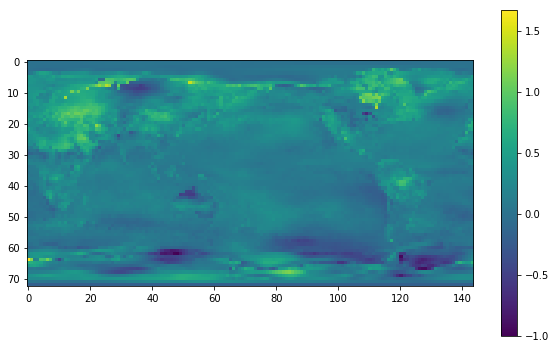

In [194]:
result = dask.array.apply_along_axis(lineartrend,0,mydat.data)
plt.figure(figsize=(10,6))
plt.imshow(10*result) # Convert to units/decade
plt.colorbar()

# Theilsen slope

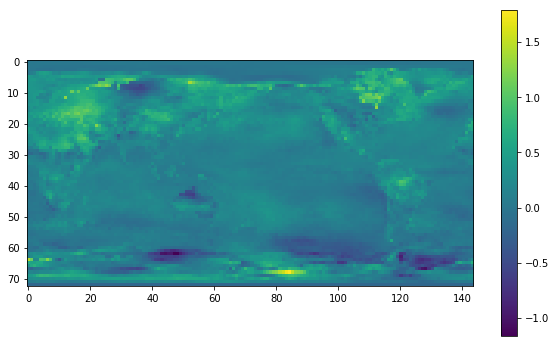

In [195]:
result = dask.array.apply_along_axis(theilslopes_fast,0,mydat.data)
plt.figure(figsize=(10,6))
plt.imshow(10*result)
plt.colorbar()

# Mann-Kendall trend test

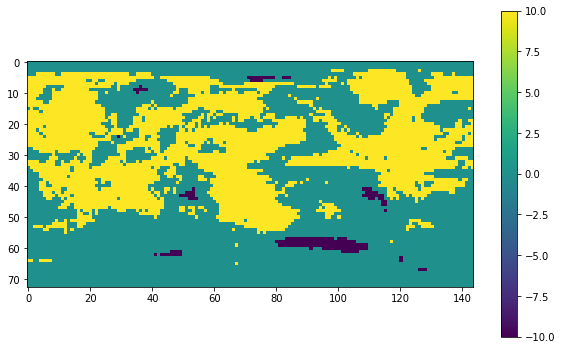

In [196]:
result = dask.array.apply_along_axis(mannkendall,0,mydat.data)
plt.figure(figsize=(10,6))
plt.imshow(10*result)
plt.colorbar()

# Remarks
This example notebook was purely created for demonstrating the functionality available in this trend framework. A good knowledge of the underlying dataset is essential for interpreting correctly the outcome of different trend tests. Trend derivation in general is problematic from re-analyses as the usage of changing observing systems in the data assimilation may lead to changing biases or spurious trends (e.g., Bengtsson et al. 2004). 

 - Bengtsson, L., S. Hagemann, and K. I. Hodges, 2004: Can climate trends be calculated from reanalysis data? Journal of Geophysical Research, 109, doi:10.1029/2004JD004536.
